In [38]:
import os
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack

NucPosSimulator path: /home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64/NucPosSimulator

   Running job1

Running: /home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64/NucPosSimulator /home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64/testdata/ESC_chr14_47450015_47750172.bed /home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64/params.txt results_nucpos/job1

-----------------------------------------
Imported 38129 nucleosome reads successfully.
Read range:	47450126:47750172
Locus begin:	47449979
Locus end:	47750319
Simulated Annealing :  1
Binding energy: -8
Seed for random number generator: 1764017908
Start temperature: 600
End temperature: 0.1
Annealing steps: 100000

Progress:   0 %	Temperature: 600.0 K	 #Nucs:      0
Progress:   0 %	Temperature: 594.8 K	 #Nucs:    665
Progress:   0 %	Temperature: 589.7 K	 #Nucs:    762
Progress:   0 %	Temperature: 584.5 K	 #Nucs:    789
Progress

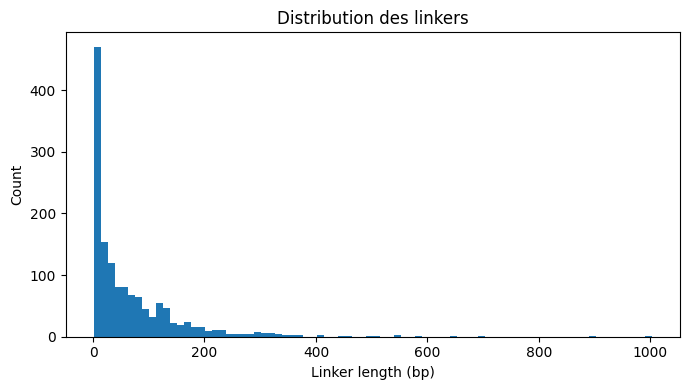

/tmp/ipykernel_14826/2045757197.py:90: RuntimeWarning: divide by zero encountered in divide
  period_bp = np.where(freq != 0, 1/np.abs(freq), np.inf)


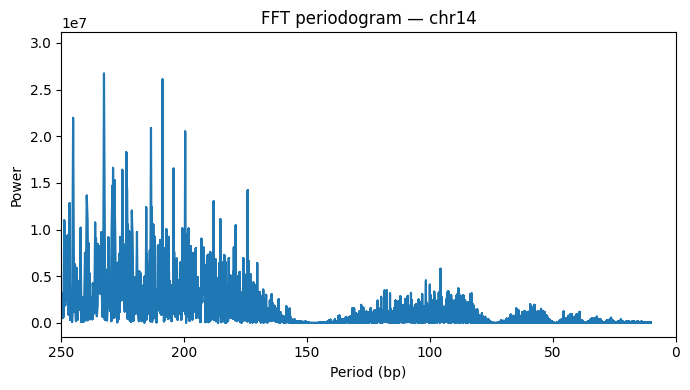


   Running job2

Running: /home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64/NucPosSimulator /home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64/testdata/ESC_chr14_47450015_47750172.bed /home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64/params_2.txt results_nucpos/job2

-----------------------------------------
Imported 38129 nucleosome reads successfully.
Read range:	47450126:47750172
Locus begin:	47449979
Locus end:	47750319
Simulated Annealing :  1
Binding energy: -8
Seed for random number generator: 1764017991
Start temperature: 600
End temperature: 0.1
Annealing steps: 100000

Progress:   0 %	Temperature: 600.0 K	 #Nucs:      0
Progress:   0 %	Temperature: 594.8 K	 #Nucs:    658
Progress:   0 %	Temperature: 589.7 K	 #Nucs:    765
Progress:   0 %	Temperature: 584.5 K	 #Nucs:    763
Progress:   0 %	Temperature: 579.5 K	 #Nucs:    806
Progress:   0 %	Temperature: 574.5 K	 #Nucs:    797
Progress:   1 %	Te

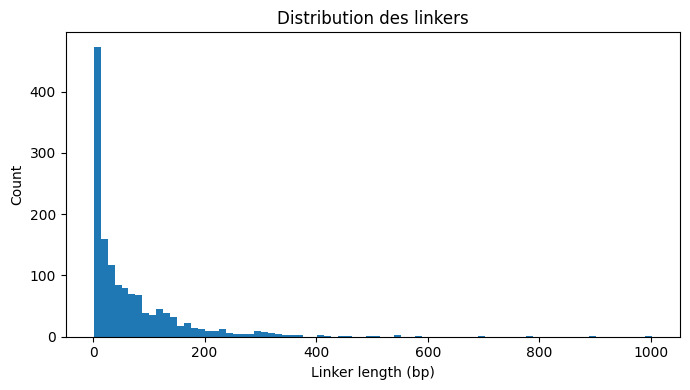

/tmp/ipykernel_14826/2045757197.py:90: RuntimeWarning: divide by zero encountered in divide
  period_bp = np.where(freq != 0, 1/np.abs(freq), np.inf)


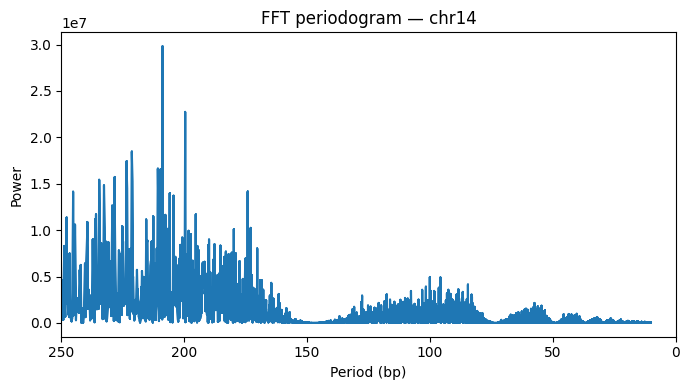


Tous les jobs sont terminés.


In [39]:
# Path to NucPosSimulator
NUCPOS_BIN = Path("/home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64/NucPosSimulator")
assert NUCPOS_BIN.exists(), f"NucPosSimulator introuvable : {NUCPOS_BIN}"
print("NucPosSimulator path:", NUCPOS_BIN)


# Run
def run_nucpos_simulator(bed_file, params_file, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    cmd = [
        str(NUCPOS_BIN),
        str(bed_file),
        str(params_file),
        str(out_dir)
    ]

    print("Running:", " ".join(cmd))
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    print(result.stdout)
    print(result.stderr)

    bed_result = out_dir / (Path(bed_file).name + ".result.bed")
    
    if not bed_result.exists():
        raise FileNotFoundError(f"Aucun fichier .result.bed produit : {bed_result}")

    return bed_result


NUC_SIZE = 147


def parse_bed_result(bed_result_path, out_dir):
    df = pd.read_csv(
        bed_result_path, sep="\t", header=None,
        names=["chr","start","end"], comment="#"
    )
    df["pos"] = ((df["start"] + df["end"]) // 2).astype(int)
    df["score"] = 1.0
    out_csv = Path(out_dir) / "parsed_positions.csv"
    df.to_csv(out_csv, index=False)
    return df, out_csv



def compute_linkers(df):
    rows = []
    for chrom, g in df.groupby("chr"):
        pos = np.sort(g["pos"].values)
        if len(pos) > 1:
            linkers = (pos[1:] - pos[:-1]) - NUC_SIZE
            rows.append(pd.DataFrame({"chr": chrom, "linker": linkers}))
    return pd.concat(rows, ignore_index=True)



def plot_linker_hist(linkers, out_dir):
    plt.figure(figsize=(7,4))
    plt.hist(linkers["linker"], bins=80)
    plt.xlabel("Linker length (bp)")
    plt.ylabel("Count")
    plt.title("Distribution des linkers")
    plt.tight_layout()
    plt.savefig(Path(out_dir) / "linker_hist.png")
    plt.show()


def build_binary_occupancy(df):
    chrom = df["chr"].iloc[0]
    pos = df[df["chr"] == chrom]["pos"].values
    start, end = pos.min() - 2000, pos.max() + 2000
    L = end - start + 1
    occ = np.zeros(L, dtype=float)
    for p in pos:
        left  = max(0, p - NUC_SIZE//2 - start)
        right = min(L-1, p + NUC_SIZE//2 - start)
        occ[left:right+1] = 1
    return occ, chrom, start, end


def plot_fft(occ, chrom, start, end, out_dir):
    f = fftpack.fft(occ - occ.mean())
    power = np.abs(f)**2
    freq = fftpack.fftfreq(len(occ), d=1.0)

    period_bp = np.where(freq != 0, 1/np.abs(freq), np.inf)
    mask = (period_bp > 10) & (period_bp < 400)

    plt.figure(figsize=(7,4))
    plt.plot(period_bp[mask], power[mask])
    plt.xlim(0,250)
    plt.gca().invert_xaxis()
    plt.xlabel("Period (bp)")
    plt.ylabel("Power")
    plt.title(f"FFT periodogram — {chrom}")
    plt.tight_layout()
    plt.savefig(Path(out_dir) / "period_spectrum.png")
    plt.show()
    

BASE = "/home/nicolas/Documents/PhD/Workspace/NucPosSimulator/NucPosSimulator_linux64"

jobs = [
    {
        "name": "job1",
        "bed": f"{BASE}/testdata/ESC_chr14_47450015_47750172.bed",
        "params": f"{BASE}/params.txt"
    },
    
    {
        "name": "job2",
        "bed": f"{BASE}/testdata/ESC_chr14_47450015_47750172.bed",
        "params": f"{BASE}/params_2.txt"
    }
]

BASE_OUT = Path("results_nucpos")
BASE_OUT.mkdir(exist_ok=True)


for job in jobs:
    print("\n==============================")
    print("   Running", job["name"])
    print("==============================\n")

    job_out = BASE_OUT / job["name"]
    bed_file = job["bed"]

    # --- 1) RUN NucPosSimulator ---
    params_file = job["params"]
    bed_result = run_nucpos_simulator(bed_file, params_file, job_out)


    # --- 2) PARSE ---
    df, csv_path = parse_bed_result(bed_result, job_out)

    # --- 3) LINKERS ---
    linkers = compute_linkers(df)
    linkers.to_csv(job_out / "linkers.csv", index=False)
    plot_linker_hist(linkers, job_out)

    # --- 4) OCCUPANCY / FFT ---
    occ, chrom, start, end = build_binary_occupancy(df)
    plot_fft(occ, chrom, start, end, job_out)

print("\nTous les jobs sont terminés.")

# .